## Importando as dependências

In [1]:
import pandas as pd

## Exemplo de dataset

In [2]:
raw_csv_data = pd.read_csv("data/condition/condition_1.csv") 
df = raw_csv_data.copy() 

In [3]:
sizes_df = df.groupby('date').count()
display(sizes_df)

,timestamp,activity
date,,
2003-05-07,720,720
2003-05-08,1440,1440
2003-05-09,1440,1440
2003-05-10,1440,1440
2003-05-11,1440,1440
2003-05-12,1440,1440
2003-05-13,1440,1440
2003-05-14,1440,1440
2003-05-15,1440,1440


## Scores Dataframe

In [4]:
raw_csv_data = pd.read_csv("data/scores.csv")
scores_df = raw_csv_data.copy()

In [5]:
scores_df.set_index('number', inplace=True)
scores_df.head()

,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
number,,,,,,,,,,,
condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


### Preenchendo os valores NULL do dataset

In [6]:
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, condition_1 to control_32
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   days       55 non-null     int64  
 1   gender     55 non-null     int64  
 2   age        55 non-null     object 
 3   afftype    23 non-null     float64
 4   melanch    20 non-null     float64
 5   inpatient  23 non-null     float64
 6   edu        53 non-null     object 
 7   marriage   23 non-null     float64
 8   work       23 non-null     float64
 9   madrs1     23 non-null     float64
 10  madrs2     23 non-null     float64
dtypes: float64(7), int64(2), object(2)
memory usage: 5.2+ KB


In [7]:
scores_df.fillna(0, inplace=True)

# Juntando os datasets

## Funções auxiliares

In [8]:
def pathCondition(id):
    return f'data/condition/condition_{id}.csv'

def pathControl(id):
    return f'data/control/control_{id}.csv'

## Separando os datasets em time series (uma por dia)
Os dias não completos, ou seja, sem 1440 instâncias, não serão utilizados.

In [9]:
count_condition = 0
count_control = 0
complete = []
not_complete = []
for i in range(1,24): 
    path = pathCondition(i)
    raw_csv_data = pd.read_csv(path) 
    df = raw_csv_data.copy() 
    sizes_df = df.groupby('date').count()
    sizes_df['path'] = path
    not_complete.append(sizes_df.loc[sizes_df['timestamp']!=1440])
    complete.append(sizes_df.loc[sizes_df['timestamp']==1440])
    count_condition += len(sizes_df.loc[sizes_df['timestamp']==1440])
    
for i in range(1,33): 
    path = pathControl(i)
    raw_csv_data = pd.read_csv(path) 
    df = raw_csv_data.copy() 
    sizes_df = df.groupby('date').count()
    sizes_df['path'] = path
    not_complete.append(sizes_df.loc[sizes_df['timestamp']!=1440])
    complete.append(sizes_df.loc[sizes_df['timestamp']==1440])
    count_control += len(sizes_df.loc[sizes_df['timestamp']==1440])

complete_df = pd.concat(complete)
not_complete_df = pd.concat(not_complete)
print(f'Number of not complete days: {len(not_complete_df)}')
print(f'Number of complete days: {len(complete_df)}')
print(f'Number of days from control: {count_control}')
print(f'Number of days from condition: {count_condition}')

Number of not complete days: 115
Number of complete days: 1029
Number of days from control: 670
Number of days from condition: 359


In [10]:
complete_df.head()

,timestamp,activity,path
date,,,
2003-05-08,1440,1440,data/condition/condition_1.csv
2003-05-09,1440,1440,data/condition/condition_1.csv
2003-05-10,1440,1440,data/condition/condition_1.csv
2003-05-11,1440,1440,data/condition/condition_1.csv
2003-05-12,1440,1440,data/condition/condition_1.csv


## Lendo as time series e armazendo-as em um novo Dataframe

In [11]:
afftype = {
    0.0: 'control',
    1.0: 'bipolar II',
    2.0: 'unipolar depressive',
    3.0: 'bipolar I'
}
time_series = []
for idx, row in complete_df.iterrows():
    number = row['path'].split('/')[-1][:-4]
    df = pd.read_csv(row['path'])
    filtered_df = df[df.date == idx].copy().set_index('timestamp')
    filtered_df['owner'] = number
    class_name = afftype[scores_df.at[number, 'afftype']]
    filtered_df['afftype'] = class_name
    filtered_df['binary_class'] = 'nondepressed' if class_name == 'control' else 'depressed'
    time_series.append(filtered_df)

time_series_df = pd.concat(time_series, keys=range(len(time_series)), names=['id', 'timestamp'])

In [12]:
time_series_df.head()

date  activity        owner  \
id timestamp                                                
0  2003-05-08 00:00:00  2003-05-08         0  condition_1   
   2003-05-08 00:01:00  2003-05-08         0  condition_1   
   2003-05-08 00:02:00  2003-05-08         0  condition_1   
   2003-05-08 00:03:00  2003-05-08         0  condition_1   
   2003-05-08 00:04:00  2003-05-08         0  condition_1   

                                    afftype binary_class  
id timestamp                                              
0  2003-05-08 00:00:00  unipolar depressive    depressed  
   2003-05-08 00:01:00  unipolar depressive    depressed  
   2003-05-08 00:02:00  unipolar depressive    depressed  
   2003-05-08 00:03:00  unipolar depressive    depressed  
   2003-05-08 00:04:00  unipolar depressive    depressed

#### Verificando se o tamanho está correto

In [13]:
print(f'Expected size: {len(complete_df)*1440}')
print(f'Size of time_series_df: {len(time_series_df)}')

Expected size: 1481760
Size of time_series_df: 1481760


# Exportando Dataframe de time series

In [14]:
time_series_df.to_csv('time_series.csv', index=True)

# Distribuição classes de depressão

In [15]:
groups = time_series_df.groupby('afftype').count().floordiv(1440).loc[:, ['owner']]
print(f'Number of days: {groups.owner.sum()}')
display(groups)

Number of days: 1029


,owner
afftype,
bipolar I,14
bipolar II,112
control,670
unipolar depressive,233


In [16]:
groups.rename(columns={'owner': 'número de dias'}, inplace=True)

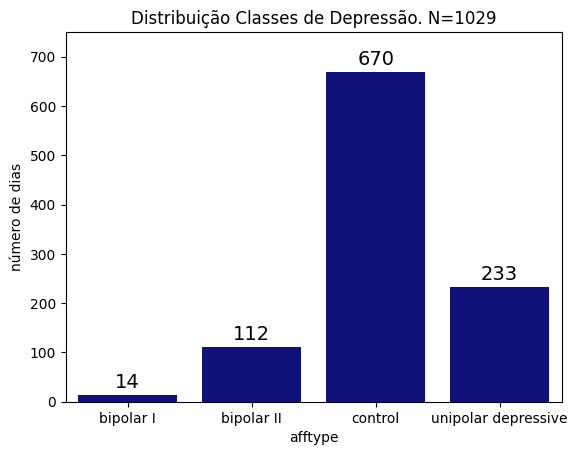

In [19]:
import seaborn as sns 
import matplotlib.pyplot as plt

plot = sns.barplot(data=groups, x='afftype', y='número de dias', errorbar=('ci', False), color='darkblue')
for i in plot.patches:
    plot.annotate(
        int(i.get_height()),
        (i.get_x() + i.get_width() / 2, i.get_height()),
        ha='center', va='baseline', fontsize=14,
        color='black', xytext=(0, 5), 
        textcoords='offset points'
    )
plt.title('Distribuição Classes de Depressão. N=1029')
plt.ylim(0, 750)
plt.show()